<a href="https://colab.research.google.com/github/sueprim/stock_predict_model/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Price                         Close
Ticker                    035900.KQ
Date                               
2002-07-01 00:00:00+00:00   60000.0
2002-07-02 00:00:00+00:00   62500.0
2002-07-03 00:00:00+00:00   65000.0
2002-07-04 00:00:00+00:00   65500.0
2002-07-05 00:00:00+00:00   65000.0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011
Epoch 2/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.4767e-04
Epoch 3/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1217e-04
Epoch 4/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0863e-04
Epoch 5/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5252e-05
Epoch 6/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.9624e-05
Epoch 7/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4120e-05
Epoch 8/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.1926e-05
Epoch 9/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.4753e-05
Epoch 10/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4804e-05
Epoch 11/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7041e-05
Epoch 12/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1063e-05
Epoch 13/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.8485e-05
Epoch 14/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 

<ipython-input-1-fdaff3de223e>:87: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start='2024-11-01', periods=future_steps, freq='M')
<ipython-input-1-fdaff3de223e>:95: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  actual_monthly = actual_df.resample('M').mean()
<ipython-input-1-fdaff3de223e>:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicted_monthly = predicted_df.resample('M').mean()


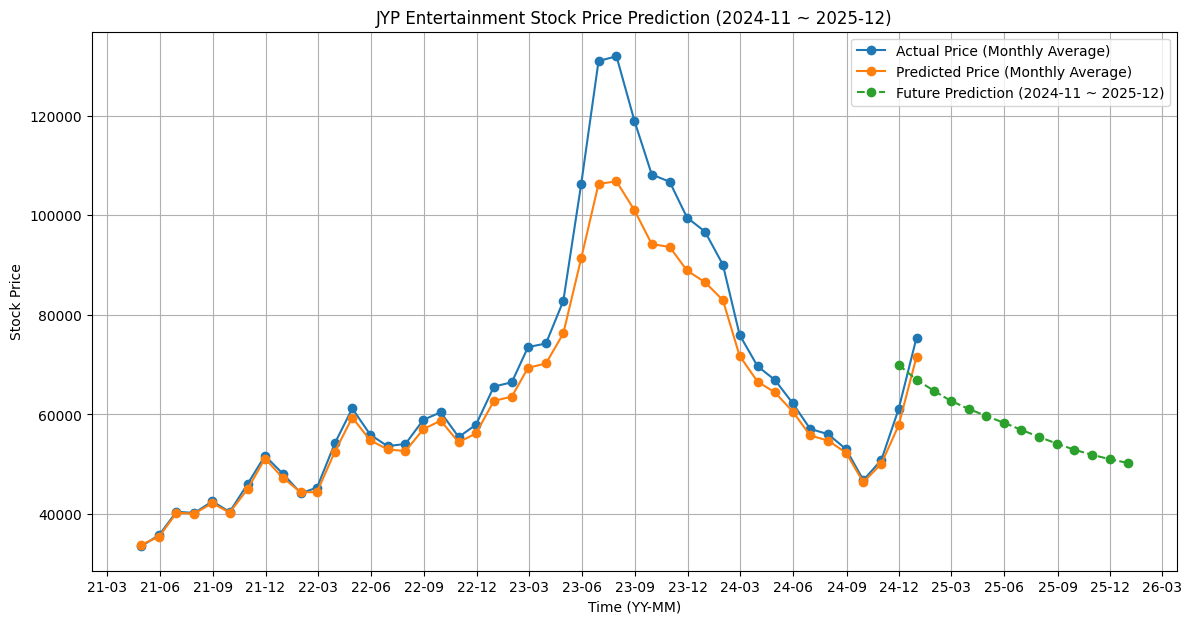

In [1]:
# 필요한 라이브러리 설치
!pip install yfinance matplotlib scikit-learn tensorflow

# 라이브러리 가져오기
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from datetime import timedelta
import matplotlib.dates as mdates

# 1. 데이터 다운로드
stock_symbol = '035900.KQ'  # JYP 엔터테인먼트 KOSDAQ 코드
today = pd.Timestamp.today().strftime('%Y-%m-%d')
data = yf.download(stock_symbol, start='2000-01-01', end=today)

# 'Close' 가격만 사용
data = data[['Close']]

# 결측치 확인 및 제거
data.dropna(inplace=True)

# 데이터 확인
print(data.head())

# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 학습 데이터 분리
time_step = 60  # 60일 데이터를 기반으로 다음 날 예측
train_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len:]

# 데이터셋 생성 함수
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# LSTM 입력 형식으로 데이터 변환
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3. 모델 생성
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 4. 모델 학습
model.fit(X_train, y_train, batch_size=32, epochs=200)

# 5. 테스트 데이터 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # 예측값 역정규화
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. 미래 예측 (2024-11 ~ 2025-12)
future_steps = 14  # 14개월 예측
future_predictions = []
current_input = scaled_data[-time_step:].reshape(1, time_step, 1)

for _ in range(future_steps):
    next_pred = model.predict(current_input)
    future_predictions.append(next_pred[0, 0])
    current_input[:, :-1, :] = current_input[:, 1:, :]
    current_input[:, -1, :] = next_pred

# 미래 예측 데이터 역정규화
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 미래 날짜 생성
future_dates = pd.date_range(start='2024-11-01', periods=future_steps, freq='M')

# 7. 월별 평균 데이터 생성 함수
def resample_monthly(data, predictions, y_test_scaled, data_index):
    actual_df = pd.DataFrame({'Actual': y_test_scaled.flatten()}, index=data_index[-len(y_test_scaled):])
    predicted_df = pd.DataFrame({'Predicted': predictions.flatten()}, index=data_index[-len(predictions):])

    # 월별 평균 계산
    actual_monthly = actual_df.resample('M').mean()
    predicted_monthly = predicted_df.resample('M').mean()

    return actual_monthly, predicted_monthly

# 월별 평균 계산
actual_monthly, predicted_monthly = resample_monthly(data, predictions, y_test_scaled, data.index)

# 미래 예측 데이터와 날짜는 그대로 사용
future_predictions_df = pd.DataFrame({'Future': future_predictions.flatten()}, index=future_dates)

# 8. 시각화
plt.figure(figsize=(14, 7))

# 실제 값과 예측 값의 월별 평균 표시
plt.plot(actual_monthly.index, actual_monthly['Actual'], label='Actual Price (Monthly Average)', marker='o')
plt.plot(predicted_monthly.index, predicted_monthly['Predicted'], label='Predicted Price (Monthly Average)', marker='o')

# 미래 예측 값 표시
plt.plot(future_predictions_df.index, future_predictions_df['Future'], label='Future Prediction (2024-11 ~ 2025-12)', marker='o', linestyle='--')

# X축 포맷 변경
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 간격
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))  # YY-MM 형식

# 제목과 레이블
plt.title('JYP Entertainment Stock Price Prediction (2024-11 ~ 2025-12)')
plt.xlabel('Time (YY-MM)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

In [2]:
"""
어떤 주식 종목을 선택해도 미래 예측 값은 떨어지는 경향을 보인다.
이유로는 과도한 epoch 사용, 그리고 전반적으로 하락의 추세로 인해 기본적으로 하락을 학습 하지 않았을까 추측
또한 미래로 갈수록 예측에 사용되는 값 또한 예측으로 생성된 값이기 때문에 장기적으로 예측은 의미가 없다고 판단
학습 수를 줄이고
"""

[*********************100%***********************]  1 of 1 completed

Price                         Close
Ticker                    035900.KQ
Date                               
2002-07-01 00:00:00+00:00   60000.0
2002-07-02 00:00:00+00:00   62500.0
2002-07-03 00:00:00+00:00   65000.0
2002-07-04 00:00:00+00:00   65500.0
2002-07-05 00:00:00+00:00   65000.0
Epoch 1/50



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0442 - val_loss: 0.0092
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 0.0062
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - val_loss: 0.008

<ipython-input-5-1acc0ef8dc0e>:80: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  actual_monthly = actual_df.resample('M').mean()
<ipython-input-5-1acc0ef8dc0e>:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicted_monthly = predicted_df.resample('M').mean()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<ipython-input-5-1acc0ef8dc0e>:103: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start='2024-12-05', periods=future_steps, freq='M')


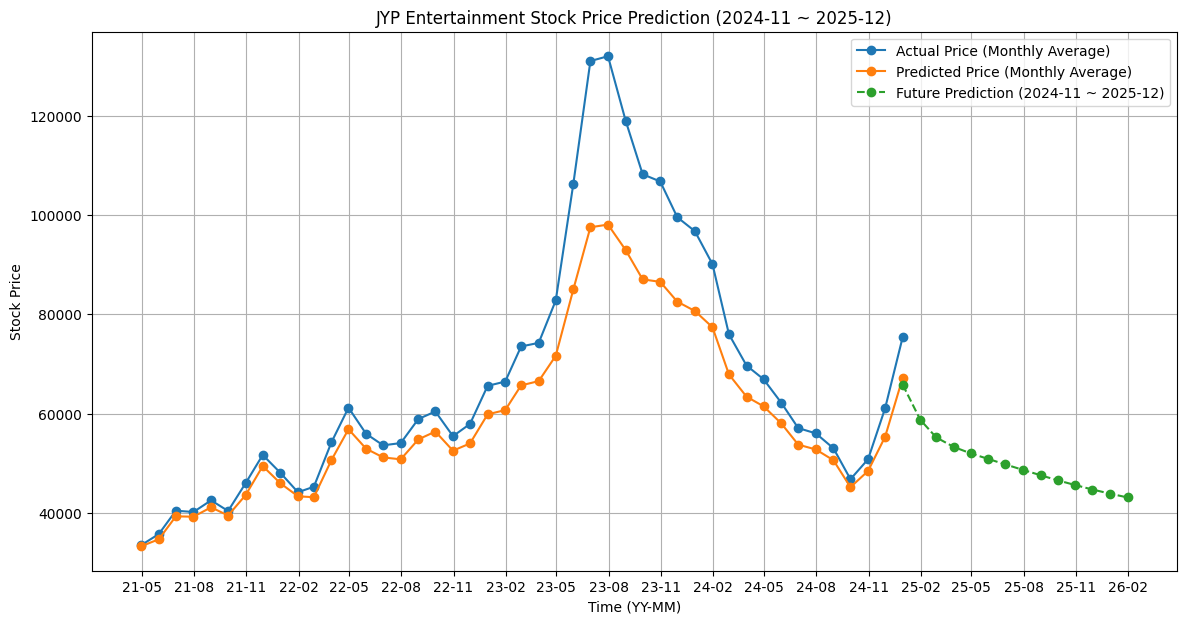

In [5]:
# 필요한 라이브러리 설치
!pip install yfinance matplotlib scikit-learn tensorflow

# 라이브러리 가져오기
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import timedelta
import matplotlib.dates as mdates

# 1. 데이터 다운로드
stock_symbol = '035900.KQ'  # JYP 엔터테인먼트 KOSDAQ 코드
today = pd.Timestamp.today().strftime('%Y-%m-%d')
data = yf.download(stock_symbol, start='2000-01-01', end=today)

# 'Close' 가격만 사용
data = data[['Close']]

# 결측치 확인 및 제거
data.dropna(inplace=True)

# 데이터 확인
print(data.head())

# 2. 데이터 전처리
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 학습 데이터 분리
time_step = 60  # 60일 데이터를 기반으로 다음 날 예측
train_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len:]

# 데이터셋 생성 함수
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# LSTM 입력 형식으로 데이터 변환
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3. 모델 생성
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),  # 드롭아웃 추가
    LSTM(50, return_sequences=False),
    Dropout(0.2),  # 드롭아웃 추가
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 4. 모델 학습
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2)  # epochs 수를 50으로 줄임

# 5. 테스트 데이터 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # 예측값 역정규화
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. 월별 평균 데이터 생성 함수
def resample_monthly(data, predictions, y_test_scaled, data_index):
    actual_df = pd.DataFrame({'Actual': y_test_scaled.flatten()}, index=data_index[-len(y_test_scaled):])
    predicted_df = pd.DataFrame({'Predicted': predictions.flatten()}, index=data_index[-len(predictions):])

    # 월별 평균 계산
    actual_monthly = actual_df.resample('M').mean()
    predicted_monthly = predicted_df.resample('M').mean()

    return actual_monthly, predicted_monthly

# 월별 평균 계산
actual_monthly, predicted_monthly = resample_monthly(data, predictions, y_test_scaled, data.index)

# 7. 미래 예측 (2024-11 ~ 2025-12)
future_steps = 14  # 14개월 예측
future_predictions = []
current_input = scaled_data[-time_step:].reshape(1, time_step, 1)

for _ in range(future_steps):
    next_pred = model.predict(current_input)
    future_predictions.append(next_pred[0, 0])
    current_input[:, :-1, :] = current_input[:, 1:, :]
    current_input[:, -1, :] = next_pred

# 미래 예측 데이터 역정규화
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 미래 날짜 생성
future_dates = pd.date_range(start='2024-12-05', periods=future_steps, freq='M')

# 8. 시각화
plt.figure(figsize=(14, 7))

# 실제 값과 예측 값의 월별 평균 표시
plt.plot(actual_monthly.index, actual_monthly['Actual'], label='Actual Price (Monthly Average)', marker='o')
plt.plot(predicted_monthly.index, predicted_monthly['Predicted'], label='Predicted Price (Monthly Average)', marker='o')

# 미래 예측 값 표시
plt.plot(future_dates, future_predictions, label='Future Prediction (2024-12 ~ 2025-12)', marker='o', linestyle='--')

# X축 포맷 변경
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 간격
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))  # YY-MM 형식

# 제목과 레이블
plt.title('JYP Entertainment Stock Price Prediction (2024-11 ~ 2025-12)')
plt.xlabel('Time (YY-MM)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()